# Определение возраста покупателей

## Введение

### Описание проекта

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:
- Анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- Контролировать добросовестность кассиров при продаже алкоголя

### Цель проекта

Постройть модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

### Описание исследования

- Провести исследовательский анализ набора данных в Jupyter.
- Обучите модель в GPU-тренажёре и сохранить результат вывода модели на экран.
- Объединить в финальной тетради Jupyter Notebook исследовательский анализ данных, код и вывод модели. Затем проанализировать результат обучения модели.

### Задачи исследования

- Провести исследовательский анализ набора фотографий.
- Подготовить данные к обучению.
- Обучить нейронную сеть и рассчитать её качество.

### Условия задачи

В статье о датасете (https://inria.hal.science/hal-01677892/document), с которым работаем, значение MAE равно 5.4 — если вы получим MAE меньше 7, это будет отличный результат!

### Исходные данные

Данные взяты с сайта ChaLearn Looking at People. Они находятся в папке /datasets/faces/.

В нашем распоряжении одна папка со всеми изображениями (/final_files) и CSV-файл labels.csv с двумя колонками: file_name и real_age.

Извлечь данные из папки вам поможет новый метод ImageDataGenerator —flow_from_dataframe(dataframe, directory, ...).

## Исследовательский анализ данных

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')

In [3]:
datagen = ImageDataGenerator(rescale=1./255)

datagen_flow = datagen.flow_from_dataframe(dataframe=labels, # датафрейм с описанием данных
                                           directory='/datasets/faces/final_files/', # папка с изображениями
                                           x_col='file_name',
                                           y_col='real_age',
                                           target_size=(150, 150),
                                           batch_size=32,
                                           class_mode='raw', # так как регрессия, нужны числовые значения, а не категориальные
                                           seed=12345) # Для воспроизводимости генерации данных

Found 7591 validated image filenames.


In [4]:
labels.shape

(7591, 2)

In [5]:
labels.describe()

,real_age
count,7591.000000
mean,31.201159
std,17.145060
min,1.000000
25%,20.000000
50%,29.000000
75%,41.000000
max,100.000000


In [6]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


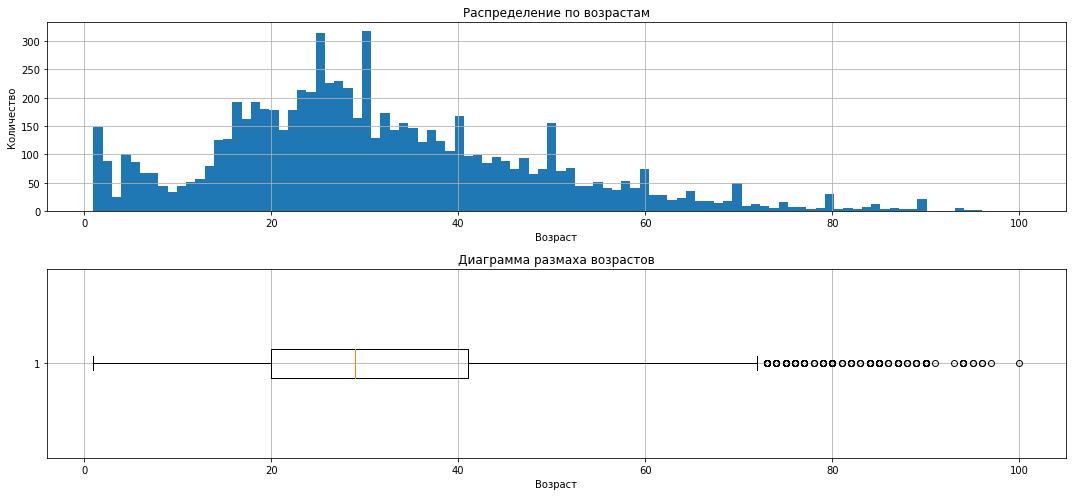

In [7]:
plt.figure(figsize=(15, 7))
plt.subplot(2, 1, 1)
plt.hist(labels['real_age'], bins=100)
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Распределение по возрастам')
plt.grid(True)

plt.subplot(2, 1, 2)
plt.boxplot(labels['real_age'], vert=False)
plt.xlabel('Возраст')
plt.title('Диаграмма размаха возрастов')
plt.grid(True)

plt.tight_layout()
plt.show()

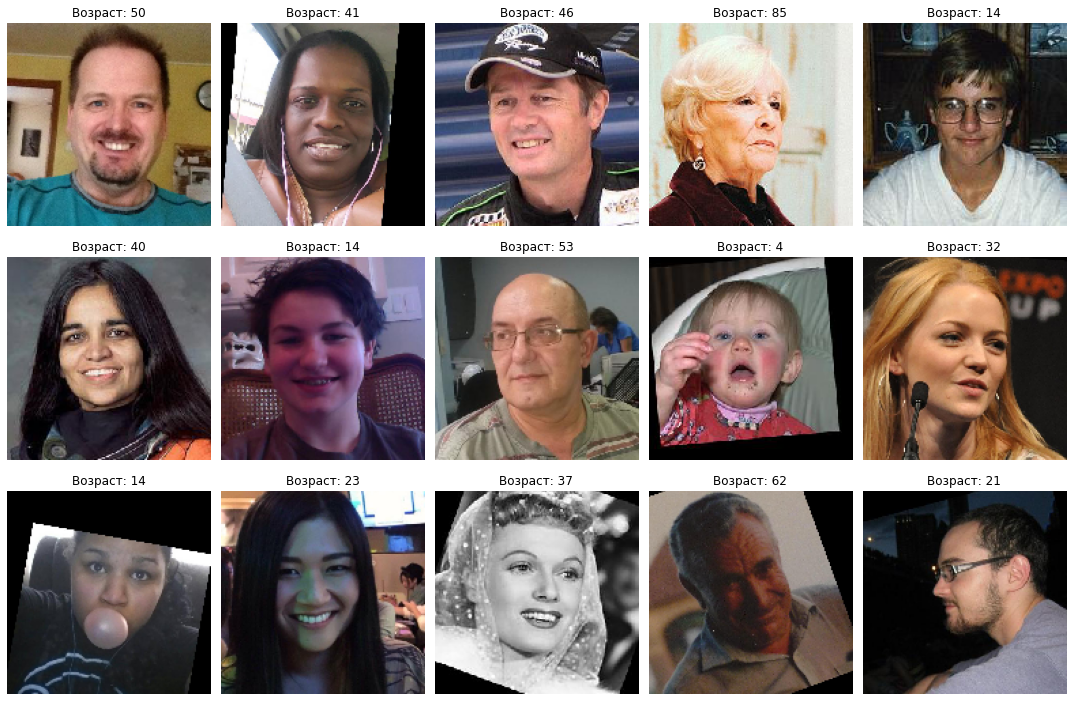

In [8]:
# Вывод 15 изображений
img, age = next(datagen_flow)  #Получаем выборку избражений и метку возраста из данных
fig, axes = plt.subplots(3, 5, figsize=(15, 10))  #создаем сетку для вывода 15 изображений

for i, ax in enumerate(axes.ravel()):
    ax.imshow(img[i])  # Отображаем изображение
    ax.set_title(f"Возраст: {int(age[i])}")  # выводим метку возраста
    ax.axis('off')  # убираем оси

plt.tight_layout() # авто корректировк расположения элементов
plt.show()

### Вывод

- Размер выборки - 7591 объект
- Основная масса фото это люди от 20 до 41 года. Минимальный возраст в выборке 1 год, а максимальный 100
- На фотографиях люди сфотографированы в разнах положениях лица и в разных локациях. Некоторые фотографии обрезаны, на некоторых лица могут сливаться с фоном или закрыты, частично предметами.

С учетом вышесказанного могут быть сложности в предсказании моделью возраста человека на фотографии.

## Обучение модели

Перенесите сюда код обучения модели и её результат вывода на экран.


(Код в этом разделе запускается в отдельном GPU-тренажёре, поэтому оформлен не как ячейка с кодом, а как код в текстовой ячейке)

```python

import numpy as np
import pandas as pd

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2

from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, horizontal_flip=True, rescale=1./255)
    train_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='training',
        seed=12345)
 
    return train_gen_flow
 
def load_test(path):

    labels = pd.read_csv(path + 'labels.csv')
    datagen = ImageDataGenerator(validation_split=0.25, rescale=1./255)
    test_gen_flow = datagen.flow_from_dataframe(
        dataframe=labels,
        directory=path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(150, 150),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=12345)
 
    return test_gen_flow
 
 
def create_model(input_shape):

    backbone = ResNet50(input_shape=input_shape, weights='imagenet', include_top=False)
    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.3))
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(Dropout(0.3))
    model.add(Dense(1, activation='relu'))
    
    optimizer = Adam(lr=0.0001)
    model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mae'])
    
    return model
 
 
def train_model(model, train_data, test_data, batch_size=None, epochs=20, steps_per_epoch=None, validation_steps=None):

    model.fit(train_data,
              validation_data=test_data,
              batch_size=batch_size, 
              epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
 
    return model

```

```
Train for 178 steps, validate for 60 steps
Epoch 1/20
2024-12-03 20:02:39.829379: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-12-03 20:02:40.223852: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 53s - loss: 396.1097 - mae: 14.6880 - val_loss: 891.0073 - val_mae: 24.9979
Epoch 2/20
178/178 - 43s - loss: 144.0936 - mae: 8.9972 - val_loss: 868.1855 - val_mae: 24.5855
Epoch 3/20
178/178 - 43s - loss: 113.6766 - mae: 8.0944 - val_loss: 339.1727 - val_mae: 13.8557
Epoch 4/20
178/178 - 42s - loss: 93.0997 - mae: 7.2202 - val_loss: 154.0530 - val_mae: 9.3924
Epoch 5/20
178/178 - 42s - loss: 81.1914 - mae: 6.7661 - val_loss: 96.9133 - val_mae: 7.3302
Epoch 6/20
178/178 - 42s - loss: 74.5233 - mae: 6.4686 - val_loss: 81.4238 - val_mae: 6.7701
Epoch 7/20
178/178 - 44s - loss: 69.0445 - mae: 6.1768 - val_loss: 73.1767 - val_mae: 6.3573
Epoch 8/20
178/178 - 49s - loss: 63.6665 - mae: 5.8580 - val_loss: 76.9608 - val_mae: 6.5643
Epoch 9/20
178/178 - 50s - loss: 57.0115 - mae: 5.5558 - val_loss: 106.7878 - val_mae: 7.5147
Epoch 10/20
178/178 - 51s - loss: 59.5577 - mae: 5.6279 - val_loss: 85.0830 - val_mae: 7.0432
Epoch 11/20
178/178 - 50s - loss: 55.0729 - mae: 5.4415 - val_loss: 99.2855 - val_mae: 7.3145
Epoch 12/20
178/178 - 50s - loss: 53.8942 - mae: 5.3608 - val_loss: 95.4714 - val_mae: 7.6656
Epoch 13/20
178/178 - 51s - loss: 50.5279 - mae: 5.2633 - val_loss: 71.5960 - val_mae: 6.2977
Epoch 14/20
178/178 - 50s - loss: 49.7178 - mae: 5.1934 - val_loss: 78.4629 - val_mae: 6.4863
Epoch 15/20
178/178 - 50s - loss: 47.0491 - mae: 5.0722 - val_loss: 86.6336 - val_mae: 6.7767
Epoch 16/20
178/178 - 51s - loss: 47.8289 - mae: 5.0328 - val_loss: 83.7898 - val_mae: 6.9606
Epoch 17/20
178/178 - 51s - loss: 47.4354 - mae: 5.0877 - val_loss: 83.3866 - val_mae: 6.8781
Epoch 18/20
178/178 - 51s - loss: 48.0907 - mae: 5.0446 - val_loss: 84.0671 - val_mae: 6.6806
Epoch 19/20
178/178 - 51s - loss: 45.9270 - mae: 4.8954 - val_loss: 83.3502 - val_mae: 6.6986
Epoch 20/20
178/178 - 50s - loss: 46.9153 - mae: 4.9465 - val_loss: 82.8842 - val_mae: 6.8991
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 12s - loss: 82.8842 - mae: 6.8991

```

## Анализ обученной модели

Получили MAE на тестовой выборке меньше 7, что соответствует техническому заданию, а именно - 6.9. То есть модель может ошибается примерно на 7 лет по сравнению с реальным возрастом человека изображенного на фотографии.

Можно заметить некоторое переобучение модели, так как на учебных данных результат несколько лучше и составляет 4.9.
Предполагаю, что вероятно, уменьшив количество нейронов до 64 в слое ` model.add(Dense(128, activation='relu'))` и в последующем до 32 мы еще немного снизим переобучение. Также потребуется снижение значений регулизации. 
Но чтобы не занимать очередь и ресурсы, получив отличный в соответствии с техническим заданием результат, дальнейшие эксперементы проводить не стал.

## Чек-лист

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Исследовательский анализ данных выполнен
- [x]  Результаты исследовательского анализа данных перенесены в финальную тетрадь
- [x]  MAE модели не больше 8
- [x]  Код обучения модели скопирован в финальную тетрадь
- [x]  Результат вывода модели на экран перенесён в финальную тетрадь
- [x]  По итогам обучения модели сделаны выводы